# 라이브러리 가져오기

In [5]:
# 필요한 라이브러리 임포트
import pandas as pd  # 데이터 처리를 위한 pandas
import numpy as np   # 수치 연산을 위한 numpy
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF 벡터화
from sklearn.linear_model import LogisticRegression  # 로지스틱 회귀 분류기
from sklearn.pipeline import Pipeline  # 머신러닝 파이프라인 구축
from sklearn.model_selection import GridSearchCV  # 하이퍼파라미터 최적화
from sklearn.metrics import accuracy_score  # 정확도 평가
import re  # 정규표현식
import nltk  # 자연어 처리
from nltk.corpus import stopwords  # 불용어 처리
from nltk.tokenize import word_tokenize  # 텍스트 토큰화

# NLTK 데이터 다운로드 
nltk.download('punkt_tab') # 토큰화를 위한 데이터
nltk.download('stopwords') # 불용어 목록

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 데이터 가져오기

In [6]:
train_df = pd.read_csv("train.csv") # 학습 데이터
test_df = pd.read_csv("test.csv") # 테스트 데이터 

train_df.head(1)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1


# 데이터 텍스트 전처리 함수
- NLP, 텍스트 마이닝의 가장 큰 핵심 영역

In [9]:
def preprocess_text(text):

    # 소문자 변환
    text = text.lower()

    # URL 제거 (정규표현식 제거)
    # 향후 스터디 : 정규표현식 공부 별도 1-2일 공부 필수
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 특수문자와 숫자 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    text = re.sub(r'\d+', '', text)      # 숫자 제거

    # 더 추가해서, 여러분들의 텍스트 전처리 함수를 만들고, 꼭 보관

    # 텍스트 토큰화 
    tokens = word_tokenize(text)

    # 불용어 제거 
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    return ' '.join(tokens)

sample_text = "Our Deeds are the Reason of this #earthquake M 1234"
print(preprocess_text(sample_text))

deeds reason earthquake


# 데이터 시각화
- 워드 클라우드 시도
  + 데이터 전처리 전/후 워드 클라우드
  + 1 x 2 배열로 비교 할 수 있도록 워드 클라우드
- target 분포 표시

In [22]:
!uv pip install wordcloud

Using Python 3.11.12 environment at: C:\Users\Admin\Desktop\lgu6P_ml_dl\.venv
Audited 1 package in 9ms


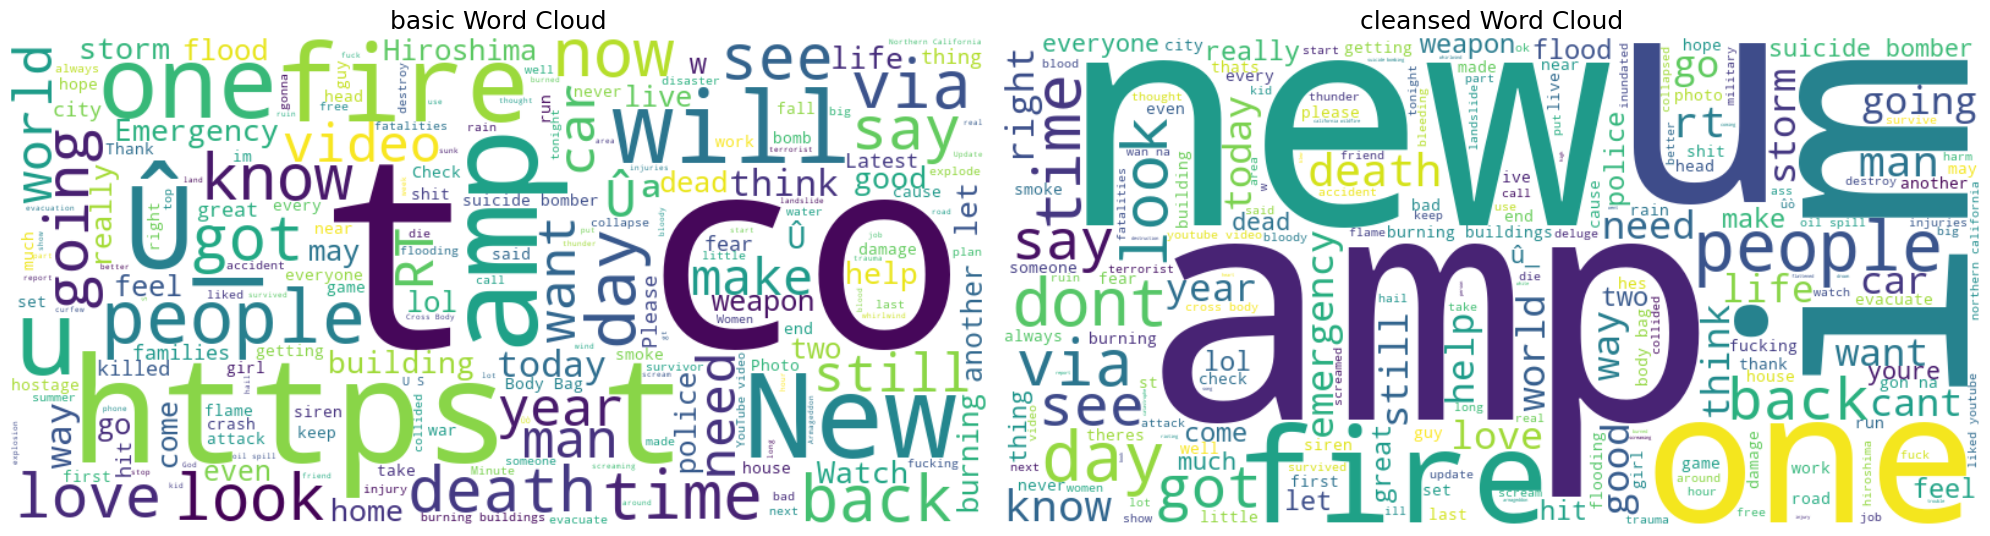

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1x2 형태로 시각화
def plot_wordclouds_side_by_side(text1, text2, title1="Original Text", title2="Cleaned Text"):
    wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(text1)
    wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(text2)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    axes[0].imshow(wordcloud1, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title(title1, fontsize=18)

    axes[1].imshow(wordcloud2, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title(title2, fontsize=18)

    plt.tight_layout()
    plt.show()

# 텍스트 준비
original_text = ' '.join(train_df['text'].dropna().astype(str))
cleaned_text = ' '.join(train_df['preprocess_text'].dropna())

# 시각화 실행
plot_wordclouds_side_by_side(original_text, cleaned_text, title1="basic Word Cloud", title2="cleansed Word Cloud")

- target 1 vs target 0 워드 클라우드 비교 해석
- 전처리 데이터만 기준

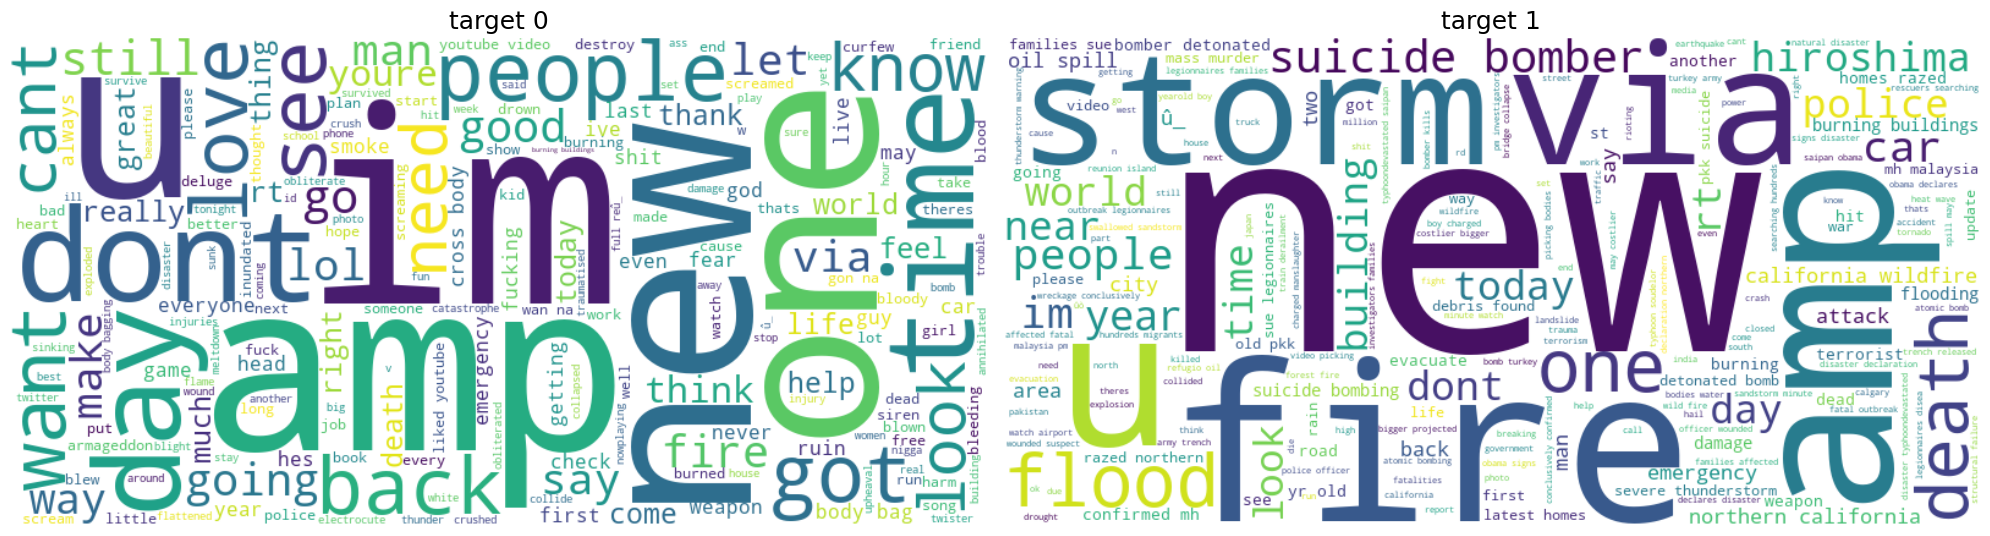

In [30]:
target_0_text = ' '.join(train_df[train_df['target'] == 0]['preprocess_text'].dropna())
target_1_text = ' '.join(train_df[train_df['target'] == 1]['preprocess_text'].dropna())

# 시각화 실행
plot_wordclouds_side_by_side(target_0_text, target_1_text, title1="target 0", title2="target 1")

## 텍스트 전처리 적용

In [10]:
train_df['preprocess_text'] = train_df['text'].apply(preprocess_text)
test_df['preprocess_text'] = test_df['text'].apply(preprocess_text)

train_df.head(1)

,id,keyword,location,text,target,preprocess_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us


In [11]:
test_df.head(1)

,id,keyword,location,text,preprocess_text
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash


# 머신러닝 파이프라인 구성

In [15]:
# 머신러닝 파이프라인 구성
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # TF-IDF 벡터화
    ('clf', LogisticRegression(random_state=42))  # 로지스틱 회귀 분류기
])

# n-gram 범위에 대한 하이퍼파라미터 그리드 정의
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]  # 단어, 2-gram, 3-gram 조합
}

# 그리드 서치 수행
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,              # 5-fold 교차 검증
    scoring='accuracy', # 정확도 기반 평가
    n_jobs=-1          # 모든 CPU 코어 사용
)

In [16]:
# 모델 학습
grid_search.fit(train_df['preprocess_text'], train_df['target'])

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'tfidf__ngram_range': [(1, ...), (1, ...), ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [18]:
# Best 파라미터 출력
print('Best Parameters', grid_search.best_params_)

Best Parameters {'tfidf__ngram_range': (1, 3)}


# 예측, 제출 파일 생성

In [20]:
test_predictions = grid_search.predict(test_df['preprocess_text'])

# 제출 파일 생성
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions
})

# 결과를 CSV 파일로 저장
submission.to_csv('submission.csv', index=False)